# Using notes' topic mixtures as features to develop models for predicting length of MV

In [205]:
import pandas as pd
import numpy as np

## Read data

In [206]:
train_mixture_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_d2_phy_nurse_48/infer/train_filtered_topics.csv'
train_duration_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_d2_phy_nurse_48/train_filtered_vent.txt'
valid_mixture_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_d2_phy_nurse_48/infer/validation_filtered_topics.csv'
valid_duration_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_d2_phy_nurse_48/validation_filtered_vent.txt'
test_mixture_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_d2_phy_nurse_48/infer/test_filtered_topics.csv'
test_duration_filename = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_d2_phy_nurse_48/test_filtered_vent.txt'

In [207]:
train_mixtures = pd.read_csv(train_mixture_filename, header=None)
train_duration = pd.read_csv(train_duration_filename, header=None, sep=' ')
train_duration = train_duration[1].astype(np.float64)
valid_mixtures = pd.read_csv(valid_mixture_filename, header=None)
valid_duration = pd.read_csv(valid_duration_filename, header=None, sep=' ')
valid_duration = valid_duration[1].astype(np.float64)
test_mixtures = pd.read_csv(test_mixture_filename, header=None)
test_duration = pd.read_csv(test_duration_filename, header=None, sep=' ')
test_duration = test_duration[1].astype(np.float64)

In [208]:
train_mixtures.shape

(1081, 50)

In [209]:
train_duration.shape

(1081,)

## Convert to binarized duration

In [210]:
bi_train_duration = (train_duration > 7 * 24).astype(int)
bi_valid_duration = (valid_duration > 7 * 24).astype(int)
bi_test_duration = (test_duration > 7 * 24).astype(int)

## Logistic regression

In [211]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve

In [212]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=200)

In [213]:
lr.fit(train_mixtures, bi_train_duration)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [214]:
valid_predictions_lr = lr.predict(valid_mixtures)

In [215]:
print(roc_auc_score(bi_valid_duration, valid_predictions_lr))
print(classification_report(bi_valid_duration, valid_predictions_lr))

0.5509259259259259
              precision    recall  f1-score   support

           0       0.83      0.66      0.73       108
           1       0.24      0.44      0.32        27

    accuracy                           0.61       135
   macro avg       0.54      0.55      0.52       135
weighted avg       0.71      0.61      0.65       135



## Naive Bayes

In [216]:
from sklearn.naive_bayes import GaussianNB

In [217]:
GNB = GaussianNB()

In [218]:
GNB.fit(train_mixtures, bi_train_duration)

GaussianNB(priors=None, var_smoothing=1e-09)

In [219]:
valid_predictions_GNB = GNB.predict(valid_mixtures)

In [220]:
print(roc_auc_score(bi_valid_duration, valid_predictions_GNB))
print(classification_report(bi_valid_duration, valid_predictions_GNB))

0.5462962962962963
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       108
           1       0.27      0.30      0.28        27

    accuracy                           0.70       135
   macro avg       0.54      0.55      0.54       135
weighted avg       0.71      0.70      0.70       135



## SVM

### Linear SVM

In [221]:
from sklearn.svm import LinearSVC

In [222]:
lsvm = LinearSVC()

In [223]:
lsvm.fit(train_mixtures, bi_train_duration)

/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [224]:
valid_predictions_lsvm = GNB.predict(valid_mixtures)

In [225]:
print(roc_auc_score(bi_valid_duration, valid_predictions_lsvm))
print(classification_report(bi_valid_duration, valid_predictions_lsvm))

0.5462962962962963
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       108
           1       0.27      0.30      0.28        27

    accuracy                           0.70       135
   macro avg       0.54      0.55      0.54       135
weighted avg       0.71      0.70      0.70       135



### Non-linear SVM

In [226]:
from sklearn.svm import SVC

In [227]:
svm = SVC()

In [228]:
svm.fit(train_mixtures, bi_train_duration)

/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [229]:
valid_predictions_svm = GNB.predict(valid_mixtures)

In [230]:
print(roc_auc_score(bi_valid_duration, valid_predictions_lsvm))
print(classification_report(bi_valid_duration, valid_predictions_lsvm))

0.5462962962962963
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       108
           1       0.27      0.30      0.28        27

    accuracy                           0.70       135
   macro avg       0.54      0.55      0.54       135
weighted avg       0.71      0.70      0.70       135



## Do Lasso regression

In [137]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [138]:
lasso = Lasso()

In [139]:
lasso.fit(train_mixtures, train_duration)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [140]:
valid_predictions_lasso = lasso.predict(valid_mixtures)

In [141]:
print(mean_squared_error(valid_duration, valid_predictions_lasso))

41810.96397345644


In [142]:
valid_predictions_lasso[0:5]

array([191.45907561, 198.95308671, 141.98132046, 154.46365004,
       222.04591674])

In [143]:
valid_duration.head()

0     68.016667
1    113.550000
2     80.450000
3    281.000000
4    161.000000
Name: 1, dtype: float64

## Grid Search LR
Logistic regression seems to be the best classifier. See how good it can be.

In [190]:
from sklearn.model_selection import GridSearchCV

In [191]:
estimator = LogisticRegression(solver='liblinear', class_weight='balanced')

In [192]:
hyperparams = {
    'C': np.arange(1.0, 1.8, step=0.02),
    'max_iter': [100, 200, 300]
              }

In [193]:
searcher = GridSearchCV(estimator=estimator, n_jobs=12, param_grid=hyperparams, scoring='roc_auc', cv=5)

In [194]:
searcher.fit(train_mixtures, bi_train_duration)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=12,
             param_grid={'C': array([1.  , 1.02, 1.04, 1.06, 1.08, 1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 ,
       1.22, 1.24, 1.26, 1.28, 1.3 , 1.32, 1.34, 1.36, 1.38, 1.4 , 1.42,
       1.44, 1.46, 1.48, 1.5 , 1.52, 1.54, 1.56, 1.58, 1.6 , 1.62, 1.64,
       1.66, 1.68, 1.7 , 1.72, 1.74, 1.76, 1.78]),
                         'max_iter

In [195]:
print(searcher.best_params_)

{'C': 1.6800000000000006, 'max_iter': 100}


In [196]:
print(searcher.best_score_)

0.6454532141480654


In [197]:
valid_predictions_lrbest = searcher.best_estimator_.predict(valid_mixtures)

In [198]:
print(roc_auc_score(bi_valid_duration, valid_predictions_lrbest))
print(classification_report(bi_valid_duration, valid_predictions_lrbest))

0.5694444444444444
              precision    recall  f1-score   support

           0       0.83      0.69      0.76       108
           1       0.27      0.44      0.33        27

    accuracy                           0.64       135
   macro avg       0.55      0.57      0.55       135
weighted avg       0.72      0.64      0.67       135



In [199]:
valid_proba_lrbest = searcher.best_estimator_.predict_proba(valid_mixtures)[:, 1]
fpr, tpr, _ = roc_curve(bi_valid_duration, valid_proba_lrbest, pos_label=1, drop_intermediate=False)

In [200]:
import matplotlib.pyplot as plt

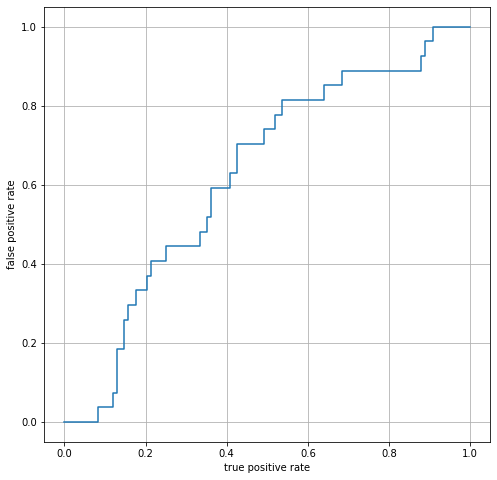

In [201]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr)
plt.xlabel('true positive rate')
plt.ylabel('false positive rate')
plt.grid()

## Try AdaBoost

In [112]:
from sklearn.ensemble import AdaBoostClassifier

In [113]:
ada = AdaBoostClassifier(base_estimator=LogisticRegression(solver='liblinear', C=1.5, max_iter=100, class_weight='balanced'), random_state=1)

In [114]:
ada.fit(train_mixtures, bi_train_duration)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=1.5,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='warn',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=None,
                                                     solver='liblinear',
                                                     tol=0.0001, verbose=0,
                                                     warm_start=False),
                   learning_r

In [115]:
valid_predictions_ada = ada.predict(valid_mixtures)

In [116]:
print(roc_auc_score(bi_valid_duration, valid_predictions_ada))
print(classification_report(bi_valid_duration, valid_predictions_ada))

0.5772820064158647
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       127
           1       0.31      0.30      0.30        27

    accuracy                           0.76       154
   macro avg       0.58      0.58      0.58       154
weighted avg       0.76      0.76      0.76       154



## Try MLP (non-linear classifier)

In [117]:
from sklearn.neural_network import MLPClassifier

In [132]:
mlp = MLPClassifier(hidden_layer_sizes=(40, 30),
                   activation='relu',
                   solver='lbfgs',
                   early_stopping=False,
                   max_iter=300,
                   random_state=1,
                   n_iter_no_change=20,
                   verbose=True)

In [133]:
mlp.fit(train_mixtures, bi_train_duration)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(40, 30), learning_rate='constant',
              learning_rate_init=0.001, max_iter=300, momentum=0.9,
              n_iter_no_change=20, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [134]:
mlp.n_iter_

7

In [135]:
valid_predictions_mlp = mlp.predict(valid_mixtures)

In [136]:
print(roc_auc_score(bi_valid_duration, valid_predictions_mlp))
print(classification_report(bi_valid_duration, valid_predictions_mlp))

0.4666083406240886
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       127
           1       0.14      0.19      0.16        27

    accuracy                           0.65       154
   macro avg       0.47      0.47      0.47       154
weighted avg       0.69      0.65      0.67       154

